# Deep Learning for Video Signal Processing (DLVSP)
## Master in Deep Learning for Audio and Video Signal Processing (MUDLAVSP)
## Universidad Autonoma de Madrid

## **Tutorial: multiple object tracking**

This tutorial will show you **how to define and run a simple multi-object tracker**. This tracker is based on the tracking-by-detection scheme. Hence, the first step is an object detector which is applied to each frame independently and the second step is data association where the detections are linked to the tracks of the previous frame.

For evaluation, you will use the [MOT16](https://motchallenge.net/data/MOT16/) dataset.  To compare tracking performance of different trackers without the effect of the object detector, the [MOTChallenge](https://motchallenge.net/data/MOT16/) provides precomputed sets of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, this tutorial uses detections computed with your own detector (`private detections`).

This tutorial can be run using cloud resources via `Google Colaboratory` or using local resources (i.e. lab computers) using Jupyter notebooks and through `Colab` (see for example this [link](https://research.google.com/colaboratory/local-runtimes.html#:~:text=In%20Colaboratory%2C%20click%20the%20%22Connect,connected%20to%20your%20local%20runtime))

Author: Juan Carlos San Miguel (juancarlos.sanmiguel@uam.es)


# 1 Setup

## 1.1 Install Python libraries

The following code will install some required packages and the utilities to compute the performance evaluation metrics `py-motmetrics` (an alternative link is available in case the official one does not work).

This tutorial has been tested in `Google Colaboratory` for the following versions:
* `Python` 3.10.X
* `Pytorch` 2.1.0 with `torchvision` 0.16.0 and `torchaudio` 2.1.0
* Support for `CUDA` libraries 12.1

At your own risk, feel free to employ other versions for the required packages.

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import torch, torchvision, torchaudio
!python --version
print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)

Python 3.10.13
2.1.1+cu118
0.16.1+cu118
2.1.1+cu118


## 1.2 Add source code location to system path

We will add the path of the source code provided in the material, so we can import and run the required functionalities for this assignment (tracker, metrics,...).

If everything has been setup correctly, the downloaded source code should be in the directory '/content/work/src/'


In [21]:
import sys,os

# add the path to the system so we can import the tracker
# sys.path.append(os.path.join(working_dir,'src/'))

# test that we can successfully import the tracker
from src.tracker.tracker import Tracker
print('If \'from tracker.tracker import Tracker\' shows no errors, you can import and execute the sample tracker code.\n')
# print('Source files of the tracker are available at the directory \'{}\':'.format(working_dir+'src/tracker/'))
# !ls '$working_dir''src/tracker/'

print('object_detector.py --> defines the object detector to be employed for tracking (FRCNN_FPN)')
print('tracker.py         --> defines the architecture for developing trackers (i.e. common functions)')
print('data_obj_detect.py --> utility for handing datasets/sequences for object detection')
print('data_track.py      --> utility for handing datasets/sequences for object tracking')
print('utils.py           --> Utilities for evaluation and plotting')

If 'from tracker.tracker import Tracker' shows no errors, you can import and execute the sample tracker code.

object_detector.py --> defines the object detector to be employed for tracking (FRCNN_FPN)
tracker.py         --> defines the architecture for developing trackers (i.e. common functions)
data_obj_detect.py --> utility for handing datasets/sequences for object detection
data_track.py      --> utility for handing datasets/sequences for object tracking
utils.py           --> Utilities for evaluation and plotting


# 2 Dataset: MOT16

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation. For the `train` set, ground-truth data and images are provided, so you can train and evaluate your algorithm. For the `test` set, only images are provided and ground-truth data is unknown to researchers. The evaluation is carried out using an evaluation server at the [MOT challenge site](https://motchallenge.net/instructions/). This evaluation scheme prevents cheating by doing training also on the `test` set.


## 2.1 Train/test split

For this assignment, we use the `train` set of MOT16 (7 sequences) and selected data from the [MOT challenge](https://motchallenge.net) as our `test` (XX sequences). The following code shows the train and test sets available in the downloaded material:

In [22]:
working_dir = '.'

#list the contents of the 'train' directory
train_dir = os.path.join(working_dir,'data/MOT16/train')
print('Train directory:')
!ls $train_dir

#list the contents of the 'test' directory
test_dir = os.path.join(working_dir,'data/MOT16/test')
print('Test directory:')
!ls $test_dir

Train directory:
MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
Test directory:
MOT16-95  MOT16-96  MOT16-97  MOT16-98	MOT16-99


## 2.2 Visualization

The following code shows the ground-truth detections for each sequence in the `train` and `test` sets.

The `MOT16Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`. The associated code is defined in the file `./src/tracker/data_track.py`

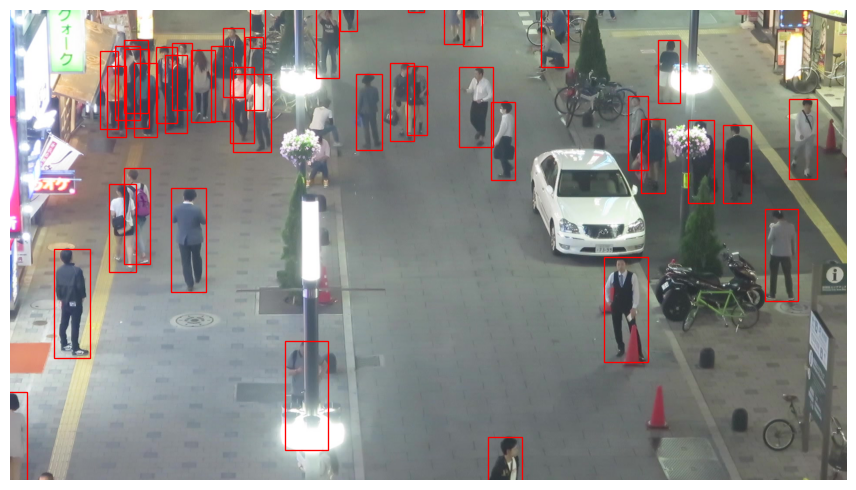

In [23]:
import matplotlib.pyplot as plt
from src.tracker.data_track import MOT16Sequences

seq_name = 'MOT16-04' #uncomment to show a single sequence
#seq_name = 'MOT16-train' #uncomment to show one frame for each sequence in the train split
#seq_name = 'MOT16-test' #uncomment to show one frame for each sequence in the test split
data_dir = os.path.join(working_dir,'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']

        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape

        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]), box[2] - box[0],box[3] - box[1],
                  fill=False,
                  edgecolor="red",
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        break #we only plot the first image for each sequence

# 3 Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN for pedestrian detection. For more information check out the corresponding PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

The associated code is defined in the file `./src/tracker/object_detector.py`

## 3.1 Model

The trained model is provided in the directory `model_dir`.

In [24]:
!pwd

/home/javiermunoz/Universidad/MasterDeepLearning/DL4VSP/Practicas/DL4VSP/dlvsp_challenge_material


In [25]:
# path for the source code of the tracker
model_dir=os.path.join(working_dir,'models/')

print('Model files of the tracker are available at the directory \'{}\':'.format(model_dir))
!ls "$model_dir"

Model files of the tracker are available at the directory './models/':
faster_rcnn_fpn.model	     finetuned_masked_rcnn.model
finetuned_faster_rcnn.model  maskrcnn_model.pth


## 3.2 Configuration
The configuration of the detector is described as follows:

In [26]:
import torch

#select GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#location of the model file
obj_detect_model_file = os.path.join(working_dir, "models/faster_rcnn_fpn.model")
#obj_detect_model_file = os.path.join(working_dir, "models/finetuned_faster_rcnn.model")

#threshold for non maximum suppression
obj_detect_nms_thresh = 0.36

#detector has been trained for two classes
num_classes=2 # 1 class (person) + background (see https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

## 3.3 Creation of the object detector

To create the object detector, we will use the functionality provided in the file `./src/tracker/object_detector.py`.

In [27]:
from src.tracker.object_detector import FRCNN_FPN, ObjDetector

# object detector

obj_detect = FRCNN_FPN(num_classes=num_classes, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)


# prints the architecture and sets the model to evaluation mode.
obj_detect.eval()

# loads detector to CPU or GPU (if available)
obj_detect.to(device)

/home/javiermunoz/miniconda3/envs/dlvsp_challenge_env/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/javiermunoz/miniconda3/envs/dlvsp_challenge_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

## 3.4 Evaluate the object detector

In addition, the trained object detector can be evaluated on the `MOT16` dataset.
To load the  MOT16 data (images and ground-truth bounding boxes), we will use functionality provide by MOT16 dev kit (`./src/tracker/data_obj_detect.py`) and Pytorch (`Dataloader`).

To perform such evaluation, we will use functionalities provided in the file `./src/tracker/utils.py`. If you run the following code, you will get an evaluation of the object detector over the `train` set (estimated execution time is 15-20 minutes).

In [28]:
import torch
import numpy as np

seed = 12345 #seed to allow repeatable results
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
from torch.utils.data import DataLoader
from src.tracker.data_obj_detect import MOT16ObjDetect
from src.tracker.utils import (evaluate_obj_detect, obj_detect_transforms)

# load train set for the MOT16 data (images and ground-truth bounding boxes)
dataset_test = MOT16ObjDetect(os.path.join(working_dir, 'data/MOT16/train'), obj_detect_transforms(train=False))

def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=os.cpu_count(), collate_fn=collate_fn)

# evaluation
# evaluate_obj_detect(obj_detect, data_loader_test)

# 4 Multi-object tracking

We provide a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

**Your task is to work using this baseline, trying to improve the performance (`MOTA` metric).**

## 4.1 Configuration
First, we must set the seed to allow repeable results

Then, we need to define the object detector, the sequences to be analyzed and the output directory.

In [30]:
import torch
import sys,os

# working directory
working_dir = '.' # assumed that steps 1.4 & 1.5 have done, so source code is in "working_dir"
sys.path.append(os.path.join(working_dir,'src/'))

from src.tracker.object_detector import FRCNN_FPN

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=num_classes, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()     # set to evaluation mode
obj_detect.to(device) # load detector to GPU or CPU

# dataset
seq_name = 'MOT16-train' # uncomment to run the tracker over the train set
#seq_name = 'MOT16-test' # uncomment to run the tracker over the test set
#seq_name = 'MOT16-05' # uncomment to run the tracker over the sequence 'MOT16-02'
data_dir = os.path.join(working_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir)
print('Loaded {:d} sequences for {:s}'.format(len(sequences),seq_name))

#output directory
output_dir = os.path.join(working_dir, 'output')

Loaded 7 sequences for MOT16-train


## 4.2 Extend the baseline tracker

The class `Tracker` in file `./src/tracker/tracker.py` contains the skeleton of the baseline tracker. You modifications and improvements should be based on this class.

As a suggestion, we provide a code example to extend the functionality of the baseline tracker by overriding the `data_association` function (which is empty in the baseline tracker). This extensions generates tracks by assigning current detections to previous detections via `Intersection over Union` in a greedy way.

In [31]:
import numpy as np
import motmetrics as mm
mm.lap.default_solver = 'lap'
from src.tracker.tracker import Tracker

tracker = Tracker(obj_detect)
print('Tracker created!')

/home/javiermunoz/miniconda3/envs/dlvsp_challenge_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javiermunoz/miniconda3/envs/dlvsp_challenge_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tracker created!


## 4.3 Run tracker
The following code runs the tracker created previously for the `train` sequences. It also prints some statistics for each sequence.

The estimated running time for the entire `train` set (7 sequences) is ~20 minutes, and for the entire `test` set (5 sequences) is ~5 minutes.

In [32]:
import time
from tqdm.autonotebook import tqdm
from src.tracker.utils import get_mot_accum

time_total = 0
mot_accums = []
results_seq = {}

for seq in sequences:
    print(f"Tracking: {seq}")
    now = time.time()

    # restart tracker state for each sequence
    tracker.reset()

    #load data
    data_loader = DataLoader(seq, batch_size=1, shuffle=False, pin_memory=True)

    #run tracker
    for frame in tqdm(data_loader):
        tracker.step(frame)

    #keep results
    results = tracker.get_results()
    results_seq[str(seq)] = results

    #perform evaluation
    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq)) #compute and store eval metrics

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    #save results to output directory
    seq.write_results(results, os.path.join(output_dir))

Tracking: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 23
Runtime for MOT16-09: 112.9 s.
Writing predictions to: ./output/MOT16-09.txt
Tracking: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 57
Runtime for MOT16-11: 203.1 s.
Writing predictions to: ./output/MOT16-11.txt
Tracking: MOT16-13


  0%|          | 0/750 [00:00<?, ?it/s]

Tracks found: 69
Runtime for MOT16-13: 211.4 s.
Writing predictions to: ./output/MOT16-13.txt
Tracking: MOT16-04


  0%|          | 0/1050 [00:00<?, ?it/s]

Tracks found: 81
Runtime for MOT16-04: 495.9 s.
Writing predictions to: ./output/MOT16-04.txt
Tracking: MOT16-10


  0%|          | 0/654 [00:00<?, ?it/s]

Tracks found: 79
Runtime for MOT16-10: 191.9 s.
Writing predictions to: ./output/MOT16-10.txt
Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 62
Runtime for MOT16-02: 171.7 s.
Writing predictions to: ./output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 68
Runtime for MOT16-05: 98.3 s.
Writing predictions to: ./output/MOT16-05.txt


## 4.4 Evaluate tracking results

The following code computes the performance evaluation metrics for the generated tracking results. You can check the definitions of the evaluation metrics at this [paper](https://arxiv.org/abs/1603.00831).

**Be aware that you can only compute the evaluation metrics for the `train` set, as it has ground-truth data available. The `test` set does not contain ground-truth data (only frames and detections), so running this code cell will not generate any output. The performance evaluation for the `test` set will be done by the course organizers.

The estimated running time for the entire `train` set (7 sequences) is ~6-7 minutes.

In [33]:
from src.tracker.utils import evaluate_mot_accums
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Runtime for all sequences: 1485.2 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-09 42.0% 51.2% 35.6% 67.9% 97.8%  26  12  13  1   82  1707   46    72 65.5% 0.085
MOT16-11 55.1% 60.6% 50.5% 80.3% 96.3%  75  41  27  7  293  1859   70    72 76.5% 0.082
MOT16-13 51.8% 51.8% 51.8% 86.5% 86.4% 110  85  23  2 1580  1575  351   197 69.9% 0.139
MOT16-04 70.1% 80.4% 62.1% 75.7% 98.0%  83  41  30 12  735 11580   80   245 73.9% 0.101
MOT16-10 48.0% 49.6% 46.5% 81.6% 87.0%  57  38  18  1 1568  2365  428   242 66.0% 0.151
MOT16-02 33.8% 47.2% 26.4% 53.2% 95.2%  62  12  38 12  494  8697  223   195 49.3% 0.095
MOT16-05 48.5% 56.9% 42.2% 69.5% 93.8% 133  56  65 12  317  2108  113   132 63.3% 0.142
OVERALL  56.1% 64.0% 49.9% 73.4% 94.2% 546 285 214 47 5069 29891 1311  1155 67.7% 0.111


As a reference, the previous code snippet achieves the following tracking results on the full `MOT16-train` sequences:

          SEQUENCE IDF1   IDP   IDR   Rcll  Prcn  GT  MT  PT  ML   FP    FN   IDs  FM  MOTA  MOTP
          MOT16-10 35.3% 40.6% 31.3% 42.0% 54.5%  57  13  23  21  4503  7448  69  120  6.4% 0.138
          MOT16-13 46.5% 64.2% 36.5% 45.1% 79.2% 110  28  34  48  1375  6393  82  124 32.6% 0.134
          MOT16-05 47.7% 53.9% 42.8% 57.8% 72.7% 133  39  64  30  1502  2917  87  103 34.9% 0.144
          MOT16-09 43.0% 48.8% 38.4% 51.9% 66.1%  26   7  14   5  1420  2559  39   66 24.5% 0.107
          MOT16-02 32.2% 49.8% 23.8% 30.8% 64.4%  62   5  22  35  3170 12858  52   93 13.5% 0.086
          MOT16-04 54.7% 56.2% 53.3% 64.1% 67.6%  83  27  37  19 14601 17064  81  172 33.2% 0.109
          MOT16-11 49.0% 54.1% 44.8% 55.8% 67.5%  75  15  32  28  2542  4166  20   39 28.7% 0.080
          OVERALL  47.2% 53.7% 42.1% 52.4% 66.9% 546 134 226 186 29113 53405 430  717 26.1% 0.111

For your final submission you should focus on improving `MOTA` for the `train` set provided as material of this assignment.

## 4.5 Visualize tracking results

The following code shows some sample results for a particular sequence.

In [34]:
results_seq.keys()

dict_keys(['MOT16-09', 'MOT16-11', 'MOT16-13', 'MOT16-04', 'MOT16-10', 'MOT16-02', 'MOT16-05'])

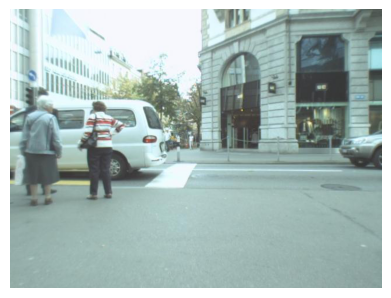

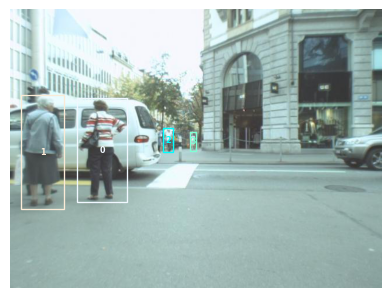

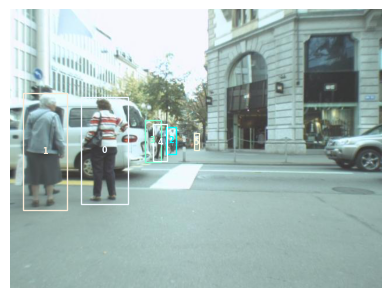

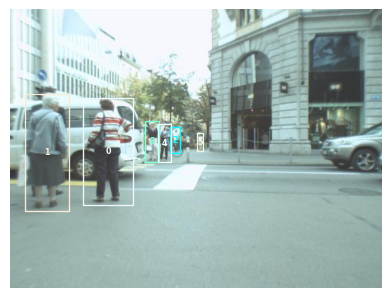

In [35]:
import matplotlib.pyplot as plt
from src.tracker.utils import plot_sequence

seq_name='MOT16-05'
plot_sequence(results_seq[seq_name],
              [s for s in sequences if str(s) == seq_name][0],
              first_n_frames=3)

# 5 Challenge results
This section provides some utilities for submitting the results of your tracker and participate in the challenge.

Before running the code of this section, you need the following:
* Results for the `train`set (`MOT16-XY.txt` files, 7 in total): these files can be obtained by running the code for section 4.3, with variable `seq_name = 'MOT16-train'` in section 4.1
* Results for the `test`set (`MOT16-XY.txt` files, 5 in total): these files can be obtained by running the code for section 4.3, with variable `seq_name = 'MOT16-test'` in section 4.1

## 5.1 Create unified tracking results for the `train` and `test` sets
To handle multiple files for tracking results, this challenge considers joining all the files into a single CSV file with all tracking results.

Please run the following code to get the unified files

In [36]:
import pandas as pd

sets=['train','test']
files_sets=[['MOT16-02','MOT16-05','MOT16-04','MOT16-09','MOT16-10', 'MOT16-11','MOT16-13'], #train files
           ['MOT16-95','MOT16-96','MOT16-97','MOT16-98','MOT16-99']] #test files

for files_set, set in zip(files_sets,sets):
  pd_files=[]
  for file in files_set:
    pd_file=pd.read_csv(os.path.join(output_dir,file+'.txt'), header = None)
    pd_file.insert(0, 'seq', file)
    pd_files.append(pd_file)

  set_preds = pd.concat(pd_files, ignore_index=True)
  set_preds.insert(0, 'id', '')
  set_preds['id'] = set_preds.iloc[:, 1:4].astype(str).apply('_'.join, axis=1)
  set_preds = set_preds.drop(set_preds.columns[8:11], axis=1)
  set_preds.to_csv(os.path.join(output_dir,'MOT16-'+set+'.csv'), index=False)
  print('Saved unified file to '+os.path.join(output_dir,'MOT16-'+set+'.csv'))

Saved unified file to ./output/MOT16-train.csv
Saved unified file to ./output/MOT16-test.csv
